In [1]:
!nvidia-smi

Thu Sep 21 13:11:28 2023       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.54.03              Driver Version: 535.54.03    CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA RTX A6000               Off | 00000000:1B:00.0 Off |                  Off |
| 30%   29C    P8               7W / 300W |  19003MiB / 49140MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "2"

In [4]:
import time
import numpy as np 
import pandas as pd 
import re,string,unicodedata
import contractions 
import re
from string import punctuation
from fastai.text.all import *
import fastai
from fastai import *
from fastai.text import * 
from sklearn.metrics import confusion_matrix

from functools import partial


import gc


import nltk
from nltk.tokenize.toktok import ToktokTokenizer
from nltk.corpus import stopwords 


from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn import metrics
from sklearn.compose import ColumnTransformer

#Warnings
import warnings
warnings.filterwarnings("ignore")

In [5]:
df=pd.read_pickle('sd_10-08-2023.pkl.gz')

In [7]:
df


ID                       created                   CRT  \
0      ISD-179723  2023-06-29T18:04:43.605+0300       Эскалация Infra   
1      ISD-179470  2023-06-29T17:54:18.285+0300          ИТ поддержка   
2      ISD-179419  2023-06-29T23:59:01.646+0300     Удаление доступов   
3      ISD-179418  2023-06-29T23:07:02.862+0300         Поддержка КИС   
4      ISD-179417  2023-06-29T22:46:39.789+0300         Поддержка КИС   
...           ...                           ...                   ...   
32425  ISD-144852  2023-04-02T12:07:02.940+0300       Эскалация Infra   
32426  ISD-144851  2023-04-02T11:16:59.832+0300         Поддержка КИС   
32427  ISD-144850  2023-04-02T10:30:00.710+0300          ИТ поддержка   
32428  ISD-144849  2023-04-02T09:17:55.798+0300  Возврат оборудования   
32429  ISD-144848  2023-04-02T07:32:00.808+0300          ИТ поддержка   

                                           Crg  \
0                         Infra T1 Integration   
1                                       Разное   
2      Закрытие доступов уволенного подрядчика   
3                             Корпоративные ИС   
4                             Корпоративные ИС   
...                                        ...   
32425                      Infra T1 Consulting   
32426                         Корпоративные ИС   
32427                           Учётные записи   
32428                             Оборудование   
32429                                   Разное   

                                                                          summary  \
0                FW: Вы назначены ответственным за исполнение по заявке # 68975 !   
1                                                       Нет доступа к  ServiceNow   
2      Необходимо закрыть доступы сотруднику аутстаф: Трущина Екатерина Сергеевна   
3                                                   доступ к папке "УПП" в Диадок   
4                                                              Дубли контрагентов   
...                                                                           ...   
32425                                               Доступ к сетевому каталогу РГ   
32426                                                          не утвержден этап    
32427                  сброс пароля для kpogonea_orb@inno.tech Погоня Констрантин   
32428                                    Сдача оборудования в связи с увольнением   
32429                                      Блокировка уч. записей AD Т1 Инновации   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          text  \
0      Коллеги, добрый день.\r\n\r\nВозможность назначения сотрудника появилось, но при назначении приходит отбойник в почту (ниже).\r\n\r\n\r\n\r\nТакже у сотрудника до сих пор нет доступа к АСД, прошу указать сроки устранения данной проблемы.\r\n\r\n\r\n\r\nНа предыдущее письмо от Вас не было получено ответа.\r\n\r\n\r\n\r\n[cid:image004.jpg@01D9AAB3.A0682CF0]\r\n\r\n\r\nС уважением,\r\nСмирнов Сергей Андреевич\r\nНачальник отдела\r\nЦентр компетенций по вычислительным комплексам\r\n[cid:image003.jpg@01D960BC.C9688A50]\r\nT:  +7(495)790-79-79\r\nM: +7966-325-60-45<tel:+79663256045>\r\nSeASmirno...   
1                                                                                                                                                                                                                                                                                                       

In [6]:
df['rtype'].unique()

array(['Infra T1 Integration', 'У меня возникла другая проблема',
       'Закрытие доступов уволенного подрядчика', '1С: Документооборот',
       '1С: Управление холдингом',
       'Включение ПО в Центр программного обеспечения',
       'Управление проектами (MS Project)',
       'Разблокировка УЗ на время отпуска', 'Проекты Jira',
       'Ошибка в работе программы', 'Ошибка', 'Запрос на обслуживание',
       'Стенды ЦА', 'Infra T1 Consulting', 'Анкетолог',
       'Создание учётной записи AD', 'Выход сотрудника',
       'Мне надо сбросить пароль в системе', 'Запрос на доступ',
       'У меня проблемы со входом в систему',
       'Согласование использования запрещенного ПО',
       'Необходимо заменить оборудование',
       'Подготовка оборудования для сотрудника',
       'Создать новый почтовый ящик', 'Создание учётной записи ',
       'Пространства Confluence',
       'Запрос на внешний USB носитель информации', 'Корпоративная почта',
       'Необходимо сдать оборудование',
       '1С

In [5]:
#label_encoder = LabelEncoder() 

#df['rtype'] = label_encoder.fit_transform(df['rtype']) 

In [6]:
# Получение подсчета классов
class_counts = df['rtype'].value_counts()

# Создание маппинга классов
class_mapping = {}
for rtype, count in class_counts.items():
    if count > 10:
        class_mapping[rtype] = rtype
    else:
        class_mapping[rtype] = 'other'

# Применение маппинга к столбцу 'rtype'
df['new_rtype'] = df['rtype'].map(class_mapping)


In [7]:
#группа где более 500
#df['new_rtype'].value_counts()[df['rtype'].value_counts().values > 500].index

In [8]:
# две самые большие категории
#class_counts = df['rtype'].value_counts()
#top_categories = class_counts.nlargest(2).index.tolist()
#df = df[df['rtype'].isin(top_categories)]

In [9]:
# Функция для обработки текста
def process_text(text):
    # Разделение слов по заглавной букве в середине слова
    text = re.sub(r'([а-яёa-z])([А-ЯЁA-Z])', r'\1 \2', text)
    # Разделение слов по предпоследней заглавной букве при наличии нескольких заглавных букв подряд
    text = re.sub(r'([А-ЯЁA-Z]+)([А-ЯЁA-Z][а-яёa-z]+)', r'\1 \2', text)
    text  = re.sub(r"(?:\n|\r)", " ", text)
   
    # Преобразование текста в нижний регистр
    text = text.lower()
    return text



df['text'] = df['text'].apply(process_text)

In [10]:
# Функция для обработки текста для summary
#def process_text(text):
    # Разделение слов по заглавной букве в середине слова
    #text = re.sub(r'([а-яёa-z])([А-ЯЁA-Z])', r'\1 \2', text)
    # Разделение слов по предпоследней заглавной букве при наличии нескольких заглавных букв подряд
    #text = re.sub(r'([А-ЯЁA-Z]+)([А-ЯЁA-Z][а-яёa-z]+)', r'\1 \2', text)
    #text  = re.sub(r"(?:\n|\r)", " ", text)
   
    # Преобразование текста в нижний регистр
    #text = text.lower()
    #return text



#df['summary'] = df['summary'].apply(process_text)

In [12]:
#удаление знаков препинания
def remove_punct(text):
  for punctuations in punctuation:
    text = text.replace(punctuations, '')
  return text


df['text'] = df['text'].apply(remove_punct)

In [14]:
#удаление знаков препинания для summary
#def remove_punct(text):
  #for punctuations in punctuation:
    #text = text.replace(punctuations, '')
  #return text


#df['summary'] = df['summary'].apply(remove_punct)

In [15]:
nltk.download('stopwords')

#stop_words = stopwords.words('english')
stopword_list = set(stopwords.words('russian'))

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/sstepanyan/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [16]:
tokenizer = ToktokTokenizer()

In [17]:
#удаление стопслов
def remove_stopwords(text, is_lower_case=False):
    tokens = tokenizer.tokenize(text)
    tokens = [token.strip() for token in tokens]
    if is_lower_case:
        filtered_tokens = [token for token in tokens if token not in stopword_list]
    else:
        filtered_tokens = [token for token in tokens if token.lower() not in stopword_list]
    filtered_text = ' '.join(filtered_tokens)    
    return filtered_text


df['text_norm'] = df['text'].apply(remove_stopwords) 

In [18]:
#удаление стопслов для summary
#def remove_stopwords(text, is_lower_case=False):
    #tokens = tokenizer.tokenize(text)
    #tokens = [token.strip() for token in tokens]
    #if is_lower_case:
        #filtered_tokens = [token for token in tokens if token not in stopword_list]
    #else:
        #filtered_tokens = [token for token in tokens if token.lower() not in stopword_list]
    #filtered_text = ' '.join(filtered_tokens)    
    #return filtered_text


#df['summary_norm'] = df['summary'].apply(remove_stopwords) 

In [19]:
df

ID                       created                   CRT  \
0      ISD-179723  2023-06-29T18:04:43.605+0300       Эскалация Infra   
1      ISD-179470  2023-06-29T17:54:18.285+0300          ИТ поддержка   
2      ISD-179419  2023-06-29T23:59:01.646+0300     Удаление доступов   
3      ISD-179418  2023-06-29T23:07:02.862+0300         Поддержка КИС   
4      ISD-179417  2023-06-29T22:46:39.789+0300         Поддержка КИС   
...           ...                           ...                   ...   
32425  ISD-144852  2023-04-02T12:07:02.940+0300       Эскалация Infra   
32426  ISD-144851  2023-04-02T11:16:59.832+0300         Поддержка КИС   
32427  ISD-144850  2023-04-02T10:30:00.710+0300          ИТ поддержка   
32428  ISD-144849  2023-04-02T09:17:55.798+0300  Возврат оборудования   
32429  ISD-144848  2023-04-02T07:32:00.808+0300          ИТ поддержка   

                                           Crg  \
0                         Infra T1 Integration   
1                                       Разное   
2      Закрытие доступов уволенного подрядчика   
3                             Корпоративные ИС   
4                             Корпоративные ИС   
...                                        ...   
32425                      Infra T1 Consulting   
32426                         Корпоративные ИС   
32427                           Учётные записи   
32428                             Оборудование   
32429                                   Разное   

                                                                          summary  \
0                FW: Вы назначены ответственным за исполнение по заявке # 68975 !   
1                                                       Нет доступа к  ServiceNow   
2      Необходимо закрыть доступы сотруднику аутстаф: Трущина Екатерина Сергеевна   
3                                                   доступ к папке "УПП" в Диадок   
4                                                              Дубли контрагентов   
...                                                                           ...   
32425                                               Доступ к сетевому каталогу РГ   
32426                                                          не утвержден этап    
32427                  сброс пароля для kpogonea_orb@inno.tech Погоня Констрантин   
32428                                    Сдача оборудования в связи с увольнением   
32429                                      Блокировка уч. записей AD Т1 Инновации   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          text  \
0      коллеги добрый день    возможность назначения сотрудника появилось но при назначении приходит отбойник в почту ниже        также у сотрудника до сих пор нет доступа к асд прошу указать сроки устранения данной проблемы        на предыдущее письмо от вас не было получено ответа        cidimage004jpg01d9aab3a0682cf0      с уважением  смирнов сергей андреевич  начальник отдела  центр компетенций по вычислительным комплексам  cidimage003jpg01d960bcc9688a50  t  74957907979  m 79663256045tel79663256045  se a smirnovt1rumailtose a smirnovt1ru  httpst1integrationruhttpst1integrationru    данное эле...   
1                                                                                                                                                                                                                                                                                                       

In [20]:
#удаление не нужных столбов
df.drop(['ID', 'created', 'CRT', 'Crg', 'CRT_id','text','rtype'], axis= 1 , inplace= True )
#df.drop(['ID', 'created', 'CRT', 'Crg', 'CRT_id','rtype', 'text'], axis= 1 , inplace= True )
#df.drop(['ID', 'created', 'CRT', 'Crg', 'CRT_id'], axis= 1 , inplace= True )

In [21]:
#df['new_rtype'].value_counts()

In [22]:
#train_df.to_pickle('/media/data/all/magerasimov/train_df.pkl')

In [23]:
#file_path = '/media/data/all/magerasimov/train_df.pkl'
#df = pd.read_pickle(file_path)

In [24]:
#test_df.to_pickle('/media/data/all/magerasimov/test_df.pkl')

In [25]:
train_df, test_df = train_test_split(df, test_size = 0.4, random_state = 33, stratify=df['new_rtype'])

In [26]:
# Посчитать количество семплов для каждого класса в тренировочной выборке
class_counts = train_df['new_rtype'].value_counts()

# Определить классы, в которых меньше 50 семплов
classes_to_convert_to_none = class_counts[class_counts < 50].index.tolist()

# Присвоить этим классам метку "none" в тренировочной и тестовой выборках
train_df.loc[train_df['new_rtype'].isin(classes_to_convert_to_none), 'new_rtype'] = 'none'
test_df.loc[test_df['new_rtype'].isin(classes_to_convert_to_none), 'new_rtype'] = 'none'

In [27]:
dls = TextDataLoaders.from_df(train_df, text_col=['text_norm', 'summary'], label_col='new_rtype', valid_df=test_df, drop_mult=0.1)

In [28]:
dls.show_batch()

In [29]:
learn = text_classifier_learner(dls, AWD_LSTM, metrics=accuracy)

In [30]:
learn.fine_tune(5,0.001)

In [61]:
learn.predict

<bound method Learner.predict of <fastai.text.learner.TextLearner object at 0x7fde0c804310>>

In [31]:
#learn.show_results()

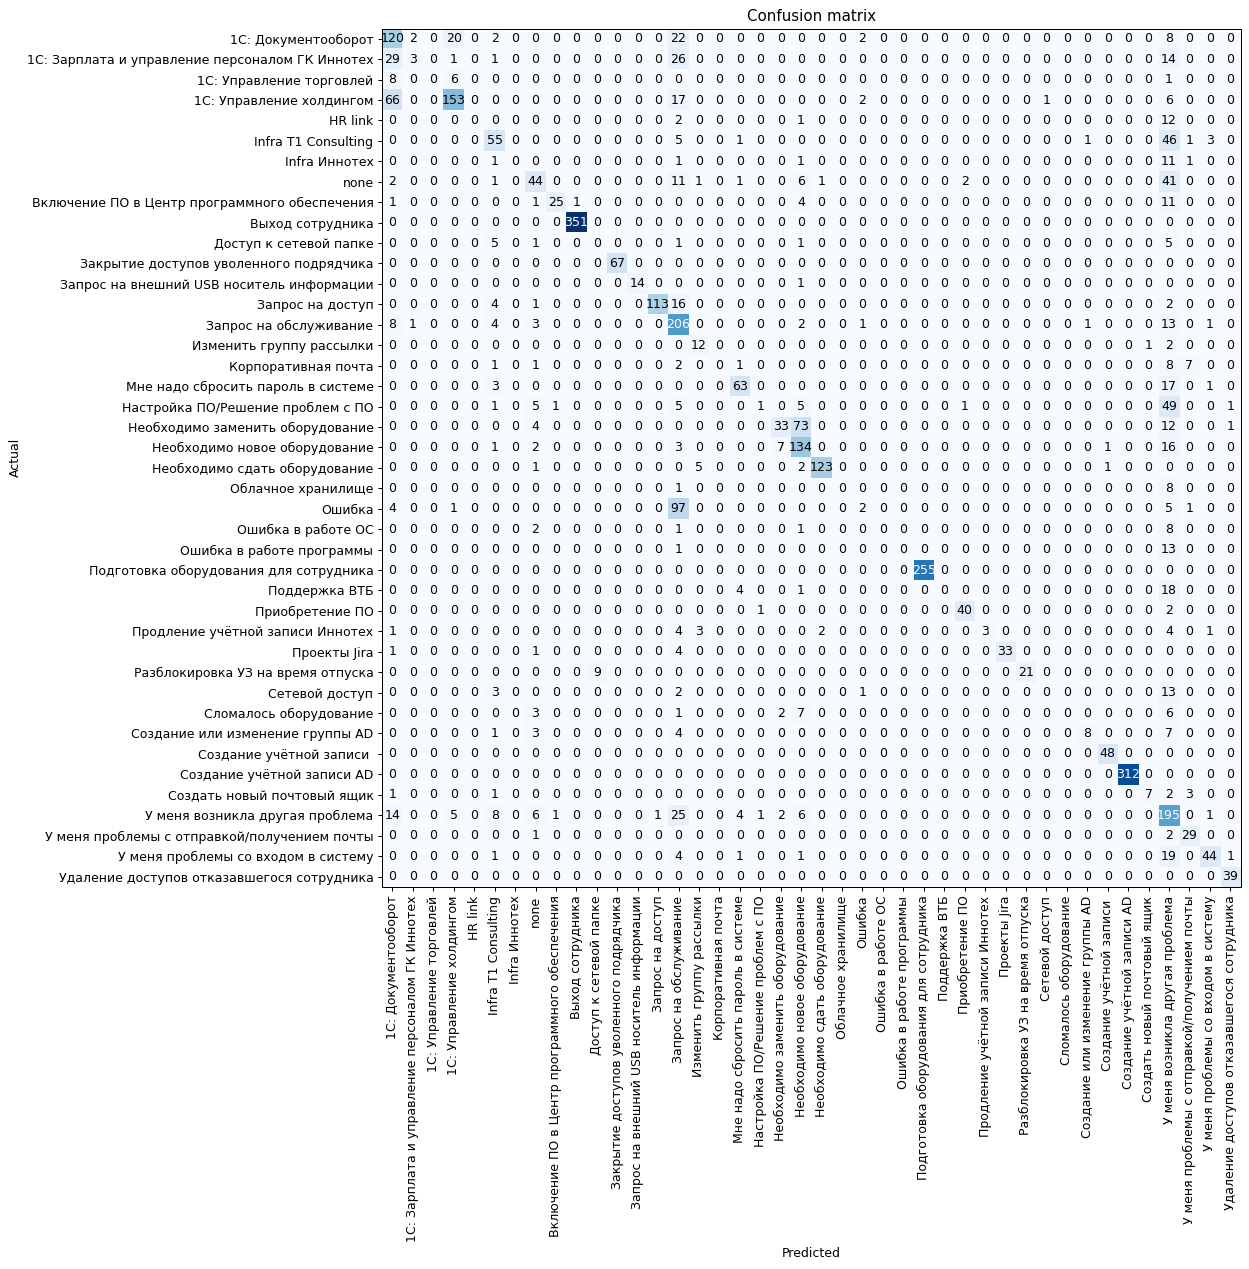

In [32]:
# confusion matrix
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix(dpi=90, figsize=(14, 14))

confusion_matrix = interp.confusion_matrix()


In [65]:
#interp.vocab

In [33]:
num_classes = len(confusion_matrix)

In [34]:
num_classes

42

In [35]:
precisions = []
recalls = []
sample_counts = []

for class_idx in range(42):
    TP = confusion_matrix[class_idx, class_idx]  # True Positives
    FP = sum(confusion_matrix[:, class_idx]) - TP  # False Positives
    FN = sum(confusion_matrix[class_idx, :]) - TP  # False Negatives

    precision = TP / (TP + FP) if TP + FP != 0 else 0
    recall = TP / (TP + FN) if TP + FN != 0 else 0

    precisions.append(round(precision, 3))  
    recalls.append(round(recall, 3))  

    sample_count = sum(confusion_matrix[class_idx, :])
    sample_counts.append(sample_count)


class_names = interp.vocab


for class_idx in range(42):
    class_name = class_names[class_idx]
    print(f"Class {class_name}: Precision = {precisions[class_idx]}, Recall = {recalls[class_idx]}, Samples = {sample_counts[class_idx]}")

Class 1С: Документооборот: Precision = 0.471, Recall = 0.682, Samples = 176
Class 1С: Зарплата и управление персоналом ГК Иннотех: Precision = 0.5, Recall = 0.041, Samples = 74
Class 1С: Управление торговлей: Precision = 0, Recall = 0.0, Samples = 15
Class 1С: Управление холдингом: Precision = 0.823, Recall = 0.624, Samples = 245
Class HR link: Precision = 0, Recall = 0.0, Samples = 15
Class Infra T1 Consulting: Precision = 0.591, Recall = 0.491, Samples = 112
Class Infra Иннотех: Precision = 0, Recall = 0.0, Samples = 15
Class none: Precision = 0.557, Recall = 0.4, Samples = 110
Class Включение ПО в Центр программного обеспечения: Precision = 0.926, Recall = 0.581, Samples = 43
Class Выход сотрудника: Precision = 0.997, Recall = 1.0, Samples = 351
Class Доступ к сетевой папке: Precision = 0.0, Recall = 0.0, Samples = 13
Class Закрытие доступов уволенного подрядчика: Precision = 1.0, Recall = 1.0, Samples = 67
Class Запрос на внешний USB носитель информации: Precision = 1.0, Recall = 0

In [36]:
precisions = []
recalls = []
sample_counts = []

precision_threshold = 0.7
recall_threshold = 0.7
sample_count_threshold = 50

for class_idx in range(42):
    TP = confusion_matrix[class_idx, class_idx]  # True Positives
    FP = sum(confusion_matrix[:, class_idx]) - TP  # False Positives
    FN = sum(confusion_matrix[class_idx, :]) - TP  # False Negatives

    precision = TP / (TP + FP) if TP + FP != 0 else 0
    recall = TP / (TP + FN) if TP + FN != 0 else 0

    precisions.append(round(precision, 3))  
    recalls.append(round(recall, 3))  

    sample_count = sum(confusion_matrix[class_idx, :])
    sample_counts.append(sample_count)

class_names = interp.vocab

for class_idx in range(42):
    class_name = class_names[class_idx]
    if (
        precisions[class_idx] > precision_threshold
        and recalls[class_idx] > recall_threshold
        and sample_counts[class_idx] > sample_count_threshold
    ):
        print(
            f"Class {class_name}: Precision = {precisions[class_idx]}, Recall = {recalls[class_idx]}, Samples = {sample_counts[class_idx]}"
        )


Class Выход сотрудника: Precision = 0.997, Recall = 1.0, Samples = 351
Class Закрытие доступов уволенного подрядчика: Precision = 1.0, Recall = 1.0, Samples = 67
Class Запрос на доступ: Precision = 0.991, Recall = 0.831, Samples = 136
Class Мне надо сбросить пароль в системе: Precision = 0.84, Recall = 0.75, Samples = 84
Class Необходимо сдать оборудование: Precision = 0.976, Recall = 0.932, Samples = 132
Class Подготовка оборудования для сотрудника: Precision = 1.0, Recall = 1.0, Samples = 255
Class Создание учётной записи AD: Precision = 1.0, Recall = 1.0, Samples = 312


In [38]:
df


summary  \
0                FW: Вы назначены ответственным за исполнение по заявке # 68975 !   
1                                                       Нет доступа к  ServiceNow   
2      Необходимо закрыть доступы сотруднику аутстаф: Трущина Екатерина Сергеевна   
3                                                   доступ к папке "УПП" в Диадок   
4                                                              Дубли контрагентов   
...                                                                           ...   
32425                                               Доступ к сетевому каталогу РГ   
32426                                                          не утвержден этап    
32427                  сброс пароля для kpogonea_orb@inno.tech Погоня Констрантин   
32428                                    Сдача оборудования в связи с увольнением   
32429                                      Блокировка уч. записей AD Т1 Инновации   

                                     new_rtype  \
0                         Infra T1 Integration   
1              У меня возникла другая проблема   
2      Закрытие доступов уволенного подрядчика   
3                          1С: Документооборот   
4                     1С: Управление холдингом   
...                                        ...   
32425                      Infra T1 Consulting   
32426                 1С: Управление холдингом   
32427       Мне надо сбросить пароль в системе   
32428            Необходимо сдать оборудование   
32429          У меня возникла другая проблема   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                     text_norm  
0      коллеги добрый день возможность назначения сотрудника появилось назначении приходит отбойник почту ниже также сотрудника сих пор доступа асд прошу указать сроки устранения данной проблемы предыдущее письмо получено ответа cidimage004jpg01d9aab3a0682cf0 уважением смирнов сергей андреевич начальник отдела центр компетенций вычислительным комплексам cidimage003jpg01d960bcc9688a50 t 74957907979 m 79663256045tel79663256045 se a smirnovt1rumailtose a smirnovt1ru httpst1integrationruhttpst1integrationru данное электронное письмо содержит информацию составляющую коммерческую тайну подлежащую разгл...  
1                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                               коллеги добрый день vpn иннотех 1200 могу зайти service nowпомогите получить доступ пожалуйста  
2                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                  необходимо перенести учётную запись сотрудника ou innolocalretiredemployees  
3      добрый де

In [48]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "2"

In [40]:
# первые 100 строк 
text_100 = df.loc[:99, 'text_norm'].tolist()

# Взять первые 1000 
text_1000 = df.loc[:999, 'text_norm'].tolist()

#время выполнения классификации для первых 100 строк
start_time = time.time()
for text in text_100:
    pred_class, pred_idx, outputs = learn.predict(text)
end_time = time.time()

#результаты и время выполнения для первых 100 строк
print(f"Predicted class for first 100 texts: {pred_class}")
print(f"Time taken for prediction (first 100 texts): {end_time - start_time} seconds")

#время выполнения классификации для первых 1000 строк
start_time = time.time()
for text in text_1000:
    pred_class, pred_idx, outputs = learn.predict(text)
end_time = time.time()

#езультаты и время выполнения для первых 1000 строк
print(f"Predicted class for first 1000 texts: {pred_class}")
print(f"Time taken for prediction (first 1000 texts): {end_time - start_time} seconds")

Predicted class for first 100 texts: Infra T1 Consulting
Time taken for prediction (first 100 texts): 2.08933687210083 seconds


Predicted class for first 1000 texts: 1С: Документооборот
Time taken for prediction (first 1000 texts): 15.83240270614624 seconds


In [ ]:
#learn.model.to('cpu')
# первые 100 строк 
text_100 = df.loc[:999999, 'text_norm'].tolist()

# первые 1000 
text_1000 = df.loc[1000:1999, 'text_norm'].tolist()

# время выполнения классификации для первых 100 строк
start_time = time.time()
for text in text_100:
    pred_class, pred_idx, outputs = learn.predict(text)
end_time = time.time()

#время выполнения для первых 100 строк
print(f"Predicted class for first 100 texts: {pred_class}")
print(f"Time taken for prediction (first 100 texts): {end_time - start_time} seconds")

#время  для первых 1000 строк
start_time = time.time()
for text in text_1000:
    pred_class, pred_idx, outputs = learn.predict(text)
end_time = time.time()

#время выполнения для первых 1000 строк
print(f"Predicted class for first 1000 texts: {pred_class}")
print(f"Time taken for prediction (first 1000 texts): {end_time - start_time} seconds")

In [57]:
precisions = []
recalls = []
sample_counts = []


for class_idx in range(42):
    TP = confusion_matrix[class_idx, class_idx]  # True Positives
    FP = sum(confusion_matrix[:, class_idx]) - TP  # False Positives
    FN = sum(confusion_matrix[class_idx, :]) - TP  # False Negatives

    precision = TP / (TP + FP) if TP + FP != 0 else 0  
    recall = TP / (TP + FN) if TP + FN != 0 else 0  

    precisions.append(precision)
    recalls.append(recall)

   
    sample_count = sum(confusion_matrix[class_idx, :])
    sample_counts.append(sample_count)

#  precision, recall  количество сэмплов для каждого класса
for class_idx in range(42):
    print(f"Class {class_idx}: Precision = {precisions[class_idx]}, Recall = {recalls[class_idx]}, Samples = {sample_counts[class_idx]}")

Class 0: Precision = 0.5393258426966292, Recall = 0.7309644670050761, Samples = 197
Class 1: Precision = 0.45652173913043476, Recall = 0.2625, Samples = 80
Class 2: Precision = 0, Recall = 0.0, Samples = 17
Class 3: Precision = 0.7970297029702971, Recall = 0.6851063829787234, Samples = 235
Class 4: Precision = 0, Recall = 0.0, Samples = 16
Class 5: Precision = 0.7619047619047619, Recall = 0.3018867924528302, Samples = 106
Class 6: Precision = 0, Recall = 0.0, Samples = 13
Class 7: Precision = 0.4090909090909091, Recall = 0.1782178217821782, Samples = 101
Class 8: Precision = 0.75, Recall = 0.6, Samples = 50
Class 9: Precision = 0, Recall = 0.0, Samples = 359
Class 10: Precision = 0, Recall = 0.0, Samples = 16
Class 11: Precision = 0.0, Recall = 0.0, Samples = 65
Class 12: Precision = 1.0, Recall = 0.9375, Samples = 16
Class 13: Precision = 0.9731543624161074, Recall = 0.8430232558139535, Samples = 172
Class 14: Precision = 0.5583126550868487, Recall = 0.8823529411764706, Samples = 255


In [67]:
num_classes = len(confusion_matrix)

In [58]:
class_counts = train_df['new_rtype'].value_counts()
print(class_counts)

Выход сотрудника                                   1761
Создание учётной записи AD                         1760
У меня возникла другая проблема                    1314
Подготовка оборудования для сотрудника             1259
Запрос на обслуживание                             1142
1С: Управление холдингом                           1140
1С: Документооборот                                 925
Необходимо новое оборудование                       866
Запрос на доступ                                    756
Необходимо сдать оборудование                       679
Необходимо заменить оборудование                    579
Ошибка                                              539
none                                                525
Infra T1 Consulting                                 509
Мне надо сбросить пароль в системе                  415
1С: Зарплата и управление персоналом ГК Иннотех     369
У меня проблемы со входом в систему                 328
Закрытие доступов уволенного подрядчика         

In [202]:
classes_to_count = [15, 17, 18, 19, 21, 22, 30, 36, 38, 40, 41, 42, 47, 48, 54, 55, 56]

sample_counts = train_df[train_df['new_rtype'].isin(classes_to_count)]['new_rtype'].value_counts()
print(sample_counts)

Series([], Name: new_rtype, dtype: int64)


In [203]:
class_counts

Выход сотрудника                                   2055
Создание учётной записи AD                         2054
У меня возникла другая проблема                    1533
Подготовка оборудования для сотрудника             1468
Запрос на обслуживание                             1332
1С: Управление холдингом                           1331
1С: Документооборот                                1079
Необходимо новое оборудование                      1011
Запрос на доступ                                    882
Необходимо сдать оборудование                       792
Необходимо заменить оборудование                    675
Ошибка                                              629
Infra T1 Consulting                                 594
Мне надо сбросить пароль в системе                  484
none                                                454
1С: Зарплата и управление персоналом ГК Иннотех     430
У меня проблемы со входом в систему                 383
Закрытие доступов уволенного подрядчика         

In [260]:
#label_encoder.classes_[vc.index]


In [206]:
vc = pd.DataFrame()

In [207]:
vc['ids'] = class_counts.index

In [208]:
vc['freq'] = class_counts.values

In [261]:
#vc['class_name'] = vc['ids'].apply(lambda x : label_encoder.classes_[x] if x < 99  else 'no')

In [210]:
vc

ids  freq
0                                  Выход сотрудника  2055
1                        Создание учётной записи AD  2054
2                   У меня возникла другая проблема  1533
3            Подготовка оборудования для сотрудника  1468
4                            Запрос на обслуживание  1332
5                          1С: Управление холдингом  1331
6                               1С: Документооборот  1079
7                     Необходимо новое оборудование  1011
8                                  Запрос на доступ   882
9                     Необходимо сдать оборудование   792
10                 Необходимо заменить оборудование   675
11                                           Ошибка   629
12                              Infra T1 Consulting   594
13               Мне надо сбросить пароль в системе   484
14                                             none   454
15  1С: Зарплата и управление персоналом ГК Иннотех   430
16              У меня проблемы со входом в систему   383
17          Закрытие доступов уволенного подрядчика   380
18                Настройка ПО/Решение проблем с ПО   353
19                         Создание учётной записи    300
20    Включение ПО в Центр программного обеспечения   262
21       Удаление доступов отказавшегося сотрудника   216
22                                  Приобретение ПО   212
23     У меня проблемы с отправкой/получением почты   209
24                                     Проекты Jira   204
25                Разблокировка УЗ на время отпуска   182
26                         1С: Управление торговлей   137
27                              Корпоративная почта   134
28                 Создание или изменение группы AD   134
29                                    Поддержка ВТБ   128
30                         Изменить группу рассылки   106
31                           Сломалось оборудование   102
32                                   Сетевой доступ    99
33                 Продление учётной записи Иннотех    92
34                                          HR link    87
35        Запрос на внешний USB носитель информации    83
36                                    Infra Иннотех    83
37                        Ошибка в работе программы    79
38                           Доступ к сетевой папке    76
39                               Ошибка в работе ОС    74
40                               Облачное хранилище    59
41                      Создать новый почтовый ящик    58
42         Создать или изменить общий почтовый ящик    54
43                          Пространства Confluence    52
44            Не работает двухфакторная авторизация    52

In [403]:
vc

ids  freq                                       class_name
0    22  2055                                 Выход сотрудника
1    64  2054                       Создание учётной записи AD
2    70  1533                  У меня возникла другая проблема
3    48  1468           Подготовка оборудования для сотрудника
4    27  1332                           Запрос на обслуживание
5     3  1331                         1С: Управление холдингом
6     0  1079                              1С: Документооборот
7    38  1011                    Необходимо новое оборудование
8    26   882                                 Запрос на доступ
9    39   792                    Необходимо сдать оборудование
10   36   675                 Необходимо заменить оборудование
11   43   629                                           Ошибка
12   10   594                              Infra T1 Consulting
13   33   484               Мне надо сбросить пароль в системе
14    1   430  1С: Зарплата и управление персоналом ГК Иннотех
15   72   383              У меня проблемы со входом в систему
16   24   380          Закрытие доступов уволенного подрядчика
17   34   353                Настройка ПО/Решение проблем с ПО
18   63   300                         Создание учётной записи 
19   21   262    Включение ПО в Центр программного обеспечения
20   73   216       Удаление доступов отказавшегося сотрудника
21   52   212                                  Приобретение ПО
22   71   209     У меня проблемы с отправкой/получением почты
23   55   204                                     Проекты Jira
24   57   182                Разблокировка УЗ на время отпуска
25    2   137                         1С: Управление торговлей
26   62   134                 Создание или изменение группы AD
27   30   134                              Корпоративная почта
28   50   128                                    Поддержка ВТБ
29   29   106                         Изменить группу рассылки
30   60   102                           Сломалось оборудование
31   59    99                                   Сетевой доступ
32   54    92                 Продление учётной записи Иннотех
33   18    90                                             none
34    9    87                                          HR link
35   25    83        Запрос на внешний USB носитель информации
36   12    83                                    Infra Иннотех
37   45    79                        Ошибка в работе программы
38   23    76                           Доступ к сетевой папке
39   44    74                               Ошибка в работе ОС
40   40    59                               Облачное хранилище
41   68    58                      Создать новый почтовый ящик
42   67    54         Создать или изменить общий почтовый ящик
43   56    52                          Пространства Confluence
44   35    52            Не работает двухфакторная авторизация
45    6    43                                               BI
46   61    41       Согласование использования запрещенного ПО
47   66    40                          Создать группу рассылки
48   99    37                                               no
49    7    36                                              DWH
50   11    34                             Infra T1 Integration
51   20    26                                        Анкетолог
52   31    22                             Корпоративный портал
53   74    20                Управление проектами (MS Project)
54   46    15                         Пакетный запрос доступов
55   37    14    Необходимо использование личного оборудования
56   13    13                  SRM (личный кабинет подрядчика)
57   28    13                         Изменение учётной записи
58   65    10                  Создать alias к почтовому ящику

In [284]:

filtered_df = df[df['new_rtype'] != 99].copy()


filtered_df.loc[:, 'rtype_decoded'] = label_encoder.inverse_transform(filtered_df['new_rtype'])


In [163]:
# Значения, по которым нужно отфильтровать
target_values = [14, 16, 18, 30, 36, 38, 40, 41, 42, 47, 48, 51, 54, 55, 56]

# Фильтрация DataFrame
filtered_df = filtered_df[filtered_df['new_rtype'].isin(target_values)]

In [490]:
filtered_df

new_rtype  \
0             11   
1             70   
2             24   
3              0   
4              3   
...          ...   
32425         10   
32426          3   
32427         33   
32428         39   
32429         70   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                     text_norm  \
0      коллеги добрый день возможность назначения сотрудника появилось назначении приходит отбойник почту ниже также сотрудника сих пор доступа асд прошу указать сроки устранения данной проблемы предыдущее письмо получено ответа cidimage004jpg01d9aab3a0682cf0 уважением смирнов сергей андреевич начальник отдела центр компетенций вычислительным комплексам cidimage003jpg01d960bcc9688a50 t 74957907979 m 79663256045tel79663256045 se a smirnovt1rumailtose a smirnovt1ru httpst1integrationruhttpst1integrationru данное электронное письмо содержит информацию составляющую коммерческую тайну подлежащую разгл...   
1                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                               коллеги добрый день vpn иннотех 1200 могу зайти service nowпомогите получить доступ пожалуйста   
2                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                  необходимо перенести учётную запись сотрудника ou innolocalretiredemployees   
3      добрый день прошу добавить доступ папке «упп » диадок спасибо best regards alexey n laukhin procurement department ts int tel 74957907979 ex1105 mobile 7 903 6765792 from артемова мария александровна m artemovat1ru sent thursday june 29 2023 601 pm to корнюшина мария александровна mkornyushinat1ru лаухин алексей николаевич a laukhint1ru cc пак алексей романович apakt1ru куликова олеся сергеевна o kulikovat1ru марусин виктор анатольевич v marusint1integrationru кичигина елена вячеславовна e kichiginat1ru гриднева ольга алексеевна o gridnevat1ru шевченко дмитрий александрович d shevchenkot1r...   
4                                                                                                                                                                                                                                                                                                                                                                                                                                                                     прошу объединить карточки контрагентов сохранением истории проверок ано дпо софт лайн эдюкейшн инн 7736228783 кпп 772501001 текущий кпп 773601001 старый   
...                                                                                                       

In [43]:
text_data_100 = dls.test_dl(df['text_norm'][:100000000000])
text_data_10 = dls.test_dl(df['text_norm'][:100])

# Для 100 строк
start_time = time.time()
preds_100 = learn.get_preds(dl=text_data_100)
end_time = time.time()
inference_time_100 = end_time - start_time
print(f"Время инференса для 100 строк: {inference_time_100} секунд")

# Для 10 строк
start_time = time.time()
preds_10 = learn.get_preds(dl=text_data_10)
end_time = time.time()
inference_time_10 = end_time - start_time
print(f"Время инференса для 10 строк: {inference_time_10} секунд")

Время инференса для 100 строк: 29.17847466468811 секунд


Время инференса для 10 строк: 3.88161039352417 секунд


In [46]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "2"

In [72]:
!nvtop -p

In [2]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "2"
#os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"

In [326]:
os.environ["CUDA_VISIBLE_DEVICES"] = "restart"

In [11]:
target='rtype'

In [127]:
os.environ["CUDA_VISIBLE_DEVICES"] = "restart"

In [1]:
!nvidia-smi

Wed Sep  6 13:46:10 2023       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.54.03              Driver Version: 535.54.03    CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA RTX A6000               Off | 00000000:1B:00.0 Off |                  Off |
| 30%   32C    P8               8W / 300W |  31978MiB / 49140MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [ ]:
nvtop